In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.datasets import fashion_mnist

In [138]:
(x_train_or,x_test_or), (y_train, y_test) = fashion_mnist.load_data()

In [139]:
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_train_or / 255) - 0.5) * 2

In [4]:
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

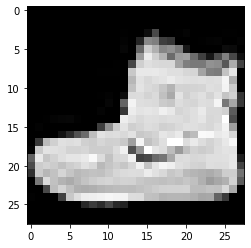

In [5]:
plt.imshow(x_train[0])

In [7]:
# Capas Custom
# 1. Funciones lambda
from keras.layers import Lambda, Input
from keras.models import Model

Square = Lambda(lambda x: x**2)

In [14]:
inp = Input(shape=(2))
# out = Square(inp)
out = Lambda(lambda x: x**2)(inp)
square_model = Model(inp, out)

In [15]:
square_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [16]:
square_model.predict([2])

1/1 [==============================] - 0s 47ms/step


array([4.], dtype=float32)

In [18]:
# Sumar 3 explícitamente

In [26]:
import tensorflow as tf
def sum_3_points(x):
  a, b, c = x[0], x[1], x[2]
  return a + b + c

In [27]:
inp = Input(shape=(3))
out = Lambda(sum_3_points)(inp)
sum_model = Model(inp, out)

In [29]:
sum_model.predict([1,2,3])

1/1 [==============================] - 0s 126ms/step


6.0

In [30]:
# Capas Custom

In [31]:
#  Capa de Sampling

In [32]:
from keras.layers import Layer
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [35]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

In [37]:
sampling_mod.predict([np.array([1., 2.]), np.array([0., -20.])])

1/1 [==============================] - 0s 74ms/step


array([1.2303427, 2.       ], dtype=float32)

In [45]:
from keras.layers.rnn.base_conv_rnn import InputSpec
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [46]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

In [49]:
kl_model.predict([np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 60ms/step


[array([[1., 2.]], dtype=float32), array([[0., 3.]], dtype=float32)]

In [50]:
kl_model.compile()

In [52]:
kl_model.evaluate([np.array([[1., 2.]]), np.array([[0., 3.]])], [np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 333ms/step - loss: 200.7144


200.7144012451172

In [53]:
# Fin de la capa KL

In [54]:
# Autoencoder

In [57]:
# Clasificador
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model

In [58]:
z_dim = 100
h_dim = 200

In [64]:
encoder_head = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(h_dim, activation = 'relu'),
])

inp = Input((28,28))
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [65]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [66]:
encoder_sample.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 200)          157000      ['input_24[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 100)          20100       ['sequential_5[0][0]']           
                                                                                                  
 dense_13 (Dense)               (None, 100)          20100       ['sequential_5[0][0]']           
                                                                                           

In [71]:
encoder_sample.predict(x_train[3:4])

1/1 [==============================] - 0s 13ms/step


array([[-3.86939597e+00, -1.27083927e-01, -1.17568052e+00,
        -2.62963629e+00, -2.20959759e+00,  6.07020020e-01,
         6.98145986e-01,  2.29709491e-01,  5.38496554e-01,
        -1.18917036e+00,  1.77362216e+00, -3.69568199e-01,
        -1.29937768e+00, -1.07382685e-01,  9.04274225e-01,
         1.03947377e+00, -7.30437279e-01, -1.67303455e+00,
        -1.52302015e+00, -1.55870986e+00, -1.27090597e+00,
        -1.49205828e+00,  6.88665450e-01, -1.97507763e+00,
         2.79643923e-01, -2.84724176e-01, -1.10089147e+00,
        -2.14361906e+00, -1.29409027e+00, -5.05124927e-01,
         3.75299752e-01,  1.16693735e+00, -3.08743382e+00,
        -7.99939394e-01,  1.18196440e+00, -7.10546255e-01,
        -2.63160205e+00,  1.16194415e+00, -1.35946894e+00,
         1.21488225e+00, -1.30301523e+00, -1.34608996e+00,
         1.16822493e+00, -1.24528933e+00,  9.36258376e-01,
         1.10938621e+00,  6.22063637e-01, -6.30581379e-03,
         1.14167225e+00, -8.53888750e-01,  6.04517460e-0

In [74]:
# Decoder

decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(28*28, activation='tanh'),
    Reshape((28,28))
])

In [82]:
vae = Sequential([encoder_mean, decoder])

1/1 [==============================] - 0s 63ms/step


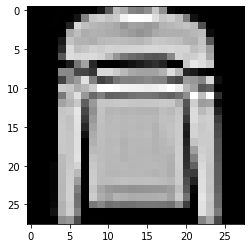

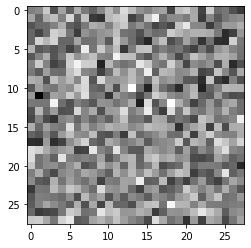

In [83]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [84]:
from keras.losses import MSE
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*28*28)

In [93]:
n_epochs = 40
batch_size = 128

history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)

Epoch 1/40
469/469 [==============================] - 3s 7ms/step - loss: 15.7769 - val_loss: 15.7487
Epoch 2/40
469/469 [==============================] - 2s 5ms/step - loss: 15.7933 - val_loss: 15.8095
Epoch 3/40
469/469 [==============================] - 2s 5ms/step - loss: 15.7394 - val_loss: 15.6022
Epoch 4/40
469/469 [==============================] - 2s 5ms/step - loss: 15.7455 - val_loss: 15.6872
Epoch 5/40
469/469 [==============================] - 3s 6ms/step - loss: 15.7375 - val_loss: 15.7238
Epoch 6/40
469/469 [==============================] - 2s 5ms/step - loss: 15.7061 - val_loss: 15.6215
Epoch 7/40
469/469 [==============================] - 2s 5ms/step - loss: 15.6954 - val_loss: 15.6545
Epoch 8/40
469/469 [==============================] - 2s 5ms/step - loss: 15.6880 - val_loss: 15.5611
Epoch 9/40
469/469 [==============================] - 3s 6ms/step - loss: 15.6876 - val_loss: 15.5898
Epoch 10/40
469/469 [==============================] - 3s 7ms/step - loss: 15.6406

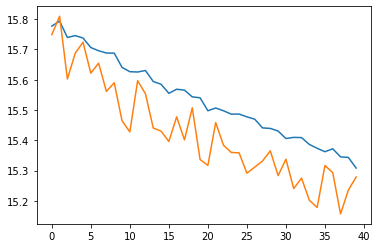

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 16ms/step


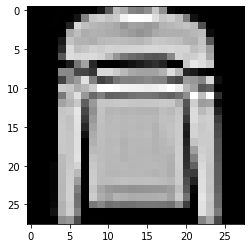

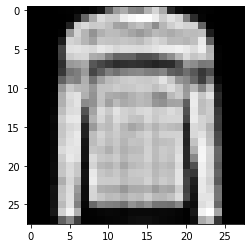

In [95]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [ ]:
# Generacion

im_fake = decoder.predict(np.random.random)

1/1 [==============================] - 0s 14ms/step


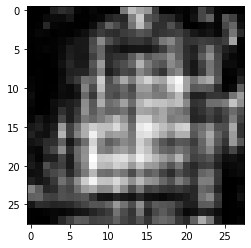

In [119]:
im_fake = decoder.predict(np.array([[np.random.random() for i in range(z_dim)]]))[0]
plt.imshow(im_fake)

In [120]:
# VAE EN 2D

In [121]:
z_dim = 2
h_dim = 200

In [122]:
encoder_head = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(h_dim, activation = 'relu'),
])

inp = Input((28,28))
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [123]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [124]:
encoder_sample.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 200)          157000      ['input_25[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 2)            402         ['sequential_9[0][0]']           
                                                                                                  
 dense_21 (Dense)               (None, 2)            402         ['sequential_9[0][0]']           
                                                                                           

In [125]:
encoder_sample.predict(x_train[3:4])

1/1 [==============================] - 0s 61ms/step


array([[-0.58466184, -2.437624  ]], dtype=float32)

In [126]:
# Decoder

decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(28*28, activation='tanh'),
    Reshape((28,28))
])

In [127]:
vae = Sequential([encoder_mean, decoder])

1/1 [==============================] - 0s 56ms/step


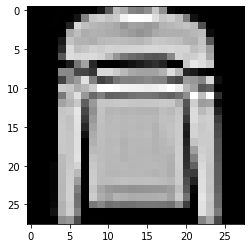

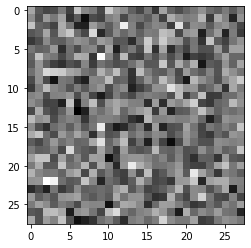

In [128]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [129]:
from keras.losses import MSE
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*28*28)

In [130]:
n_epochs = 40
batch_size = 128

history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)

Epoch 1/40
469/469 [==============================] - 4s 7ms/step - loss: 134.7744 - val_loss: 110.5434
Epoch 2/40
469/469 [==============================] - 3s 6ms/step - loss: 107.1708 - val_loss: 104.1987
Epoch 3/40
469/469 [==============================] - 3s 6ms/step - loss: 102.1204 - val_loss: 100.2997
Epoch 4/40
469/469 [==============================] - 3s 6ms/step - loss: 98.9449 - val_loss: 97.4942
Epoch 5/40
469/469 [==============================] - 2s 5ms/step - loss: 96.5550 - val_loss: 95.6231
Epoch 6/40
469/469 [==============================] - 2s 5ms/step - loss: 94.8028 - val_loss: 93.6792
Epoch 7/40
469/469 [==============================] - 2s 5ms/step - loss: 93.5912 - val_loss: 93.1383
Epoch 8/40
469/469 [==============================] - 3s 6ms/step - loss: 92.5574 - val_loss: 91.8359
Epoch 9/40
469/469 [==============================] - 2s 5ms/step - loss: 91.6268 - val_loss: 90.7932
Epoch 10/40
469/469 [==============================] - 2s 5ms/step - loss: 9

In [131]:
# Visualizamos el espacio latente

1875/1875 [==============================] - 2s 1ms/step


ValueError: ignored

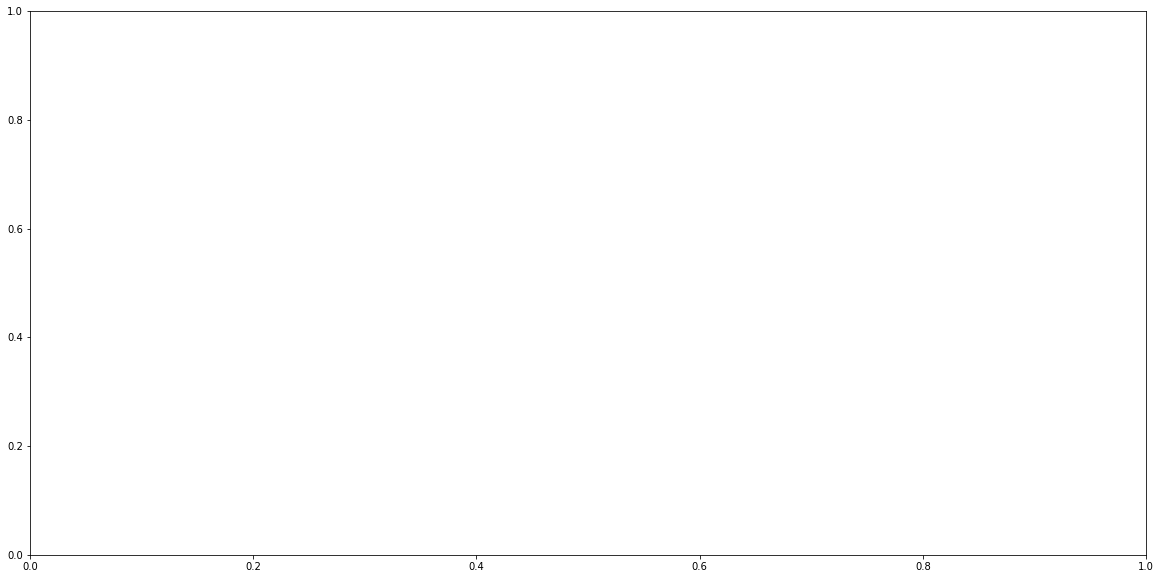

In [140]:
z_test = encoder_mean.predict(x_test)
plt.figure(figsize=(20,10))
plt.scatter(z_test[:,0], z_test[:,1], s=0.4, c=y_test, cmap='jet')

1875/1875 [==============================] - 2s 1ms/step


ValueError: ignored

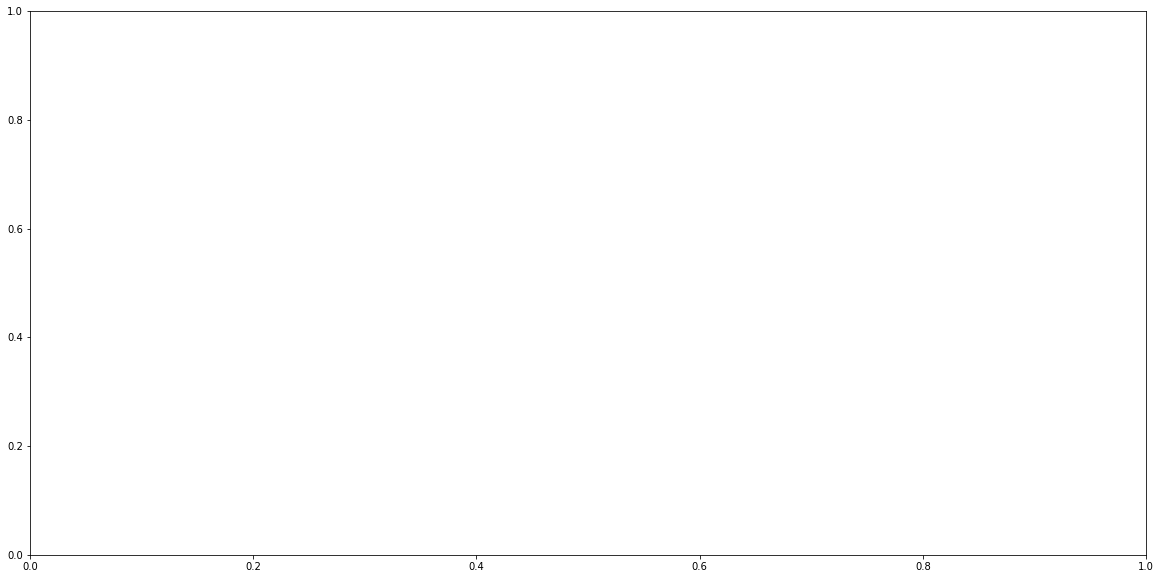

In [141]:
z_train = encoder_mean.predict(x_train)
plt.figure(figsize=(20,10))
plt.scatter(z_train[:,0], z_train[:,1], s=0.4, c=y_train, cmap='jet')